# Regression Final Project

In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
from csv import writer
import re
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',100)
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
gb=GradientBoostingRegressor()
from sklearn.tree import ExtraTreeRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

## Web Scraping

In [2]:
def house_scraping(url,csv):
    url = "https://www.hepsiemlak.com/ankara-kiralik"
    page = requests.get(url)

    soup = BeautifulSoup(page.content,'html.parser')
    lists = soup.find_all('li',class_="listing-item")

    with open(csv,'a',encoding='utf8',newline='') as f:
        csv_writer = writer(f)
        header = ['Description','Weekend','Area','Age','Floor','Price']
        csv_writer.writerow(header)
        for list in lists:
            description = list.find('header',class_ = 'list-view-header').text.replace('\n','')
            weekend = list.find('span',class_ = 'celly houseRoomCount').text.replace('\n','')
            area = list.find('span',class_ = 'celly squareMeter list-view-size').text.replace('\n','')
            age = list.find('span',class_ = 'celly buildingAge').text.replace('\n','')
            floor = list.find('span',class_ = 'celly floortype').text.replace('\n','')
            price = list.find('span',class_ = 'list-view-price').text.replace('\n','')
            info = [description,weekend,area,age,floor,price]
            csv_writer.writerow(info)

In [3]:
def county(name,page):

    for i in range(page):
        if i == 0:
            house_scraping(url=f"https://www.hepsiemlak.com/{name}-kiralik",csv=f"hepsiemlak_{name}.csv")
        else:
            house_scraping(url=f"https://www.hepsiemlak.com/{name}-kiralik?page={i+1}",csv=f"hepsiemlak_{name}.csv")

In [4]:
county("ankara",10)

In [5]:
df = pd.read_csv("hepsiemlak_ankara.csv")
df

,Description,Weekend,Area,Age,Floor,Price
0,Description,Weekend,Area,Age,Floor,Price
1,Description,Weekend,Area,Age,Floor,Price
2,Description,Weekend,Area,Age,Floor,Price
3,Description,Weekend,Area,Age,Floor,Price
4,Description,Weekend,Area,Age,Floor,Price
5,Description,Weekend,Area,Age,Floor,Price
6,Description,Weekend,Area,Age,Floor,Price
7,Description,Weekend,Area,Age,Floor,Price
8,Description,Weekend,Area,Age,Floor,Price


## EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Description  999 non-null    object
 1   Weekend      999 non-null    object
 2   Area         999 non-null    object
 3   Age          999 non-null    object
 4   Floor        969 non-null    object
 5   Price        999 non-null    object
dtypes: object(6)
memory usage: 47.0+ KB


In [ ]:
df.isnull().sum()

Description     0
Weekend         0
Area            0
Age             0
Floor          30
Price           0
dtype: int64

In [ ]:
df.columns

Index(['Description', 'Weekend', 'Area', 'Age', 'Floor', 'Price'], dtype='object')

In [ ]:
df.Weekend.value_counts()

3 + 1      430
2 + 1      200
1 + 1      120
4 + 1      110
5 + 1       50
Weekend     39
8 + 4       30
2 + 2       20
Name: Weekend, dtype: int64

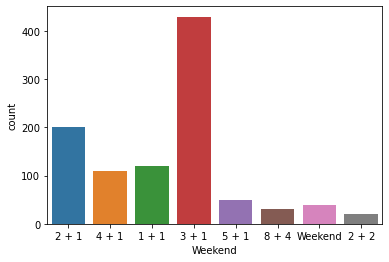

In [ ]:
sns.countplot(df.Weekend);

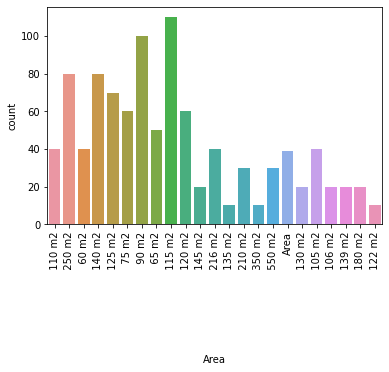

In [ ]:
sns.countplot(df.Area);
plt.xticks(rotation=90);

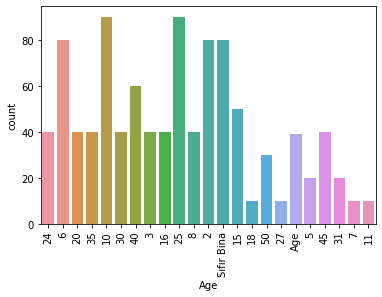

In [ ]:
sns.countplot(df.Age);
plt.xticks(rotation=90);

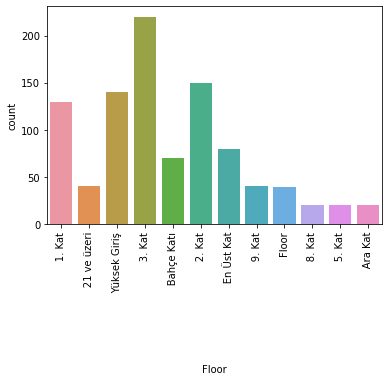

In [ ]:
sns.countplot(df.Floor);
plt.xticks(rotation=90);

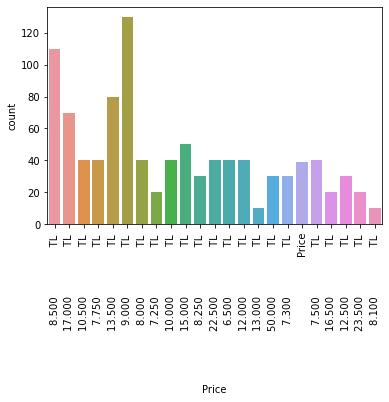

In [ ]:
sns.countplot(df.Price);
plt.xticks(rotation=90);

## Feature Engineering

In [ ]:
df['Weekend'].replace({'[^0-9]+':''},regex=True,inplace=True)

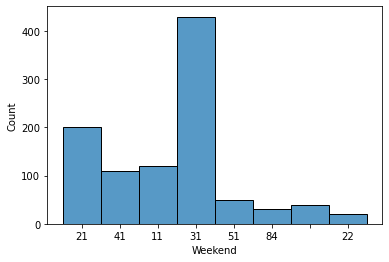

In [ ]:
sns.histplot(df.Weekend);

In [ ]:
for i in range(len(df)):
    try:
        df.Area.iloc[i] = int(re.split(r"\s+",df.Area.iloc[i])[1])
    except:

        pass

for i in range(len(df)):
    try:
        if type(df.Area.iloc[i]) == str:
            df = df.drop(i)
    except:
        pass

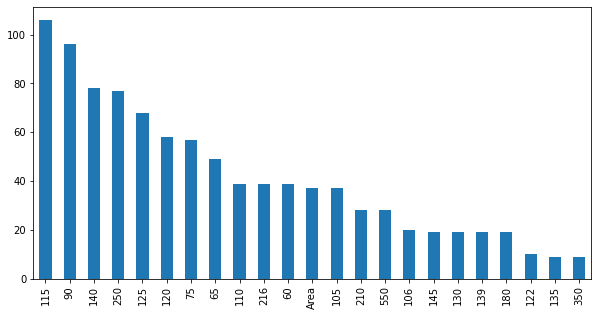

In [ ]:
plt.figure(figsize=(10,5))
df["Area"].value_counts().plot.bar();

In [ ]:
df.Age

0              24
1               6
2               6
3              20
4              35
          ...    
994    Sıfır Bina
995            45
996             2
997            15
998            11
Name: Age, Length: 960, dtype: object

In [ ]:
df['Age'].replace({' Yaşında':'','Sıfır Bina':0},regex=True,inplace=True)

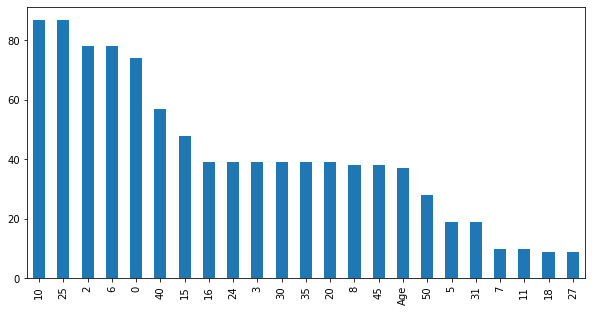

In [ ]:
plt.figure(figsize=(10,5))
df["Age"].value_counts().plot.bar();

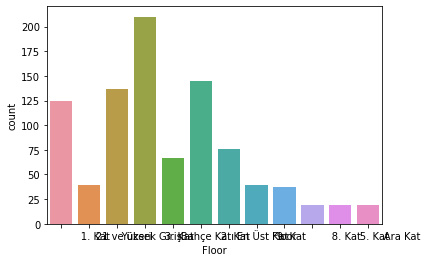

In [ ]:
sns.countplot(df.Floor);

In [ ]:
floor_list = []
for i in range(len(df)):
    try:
        df.Floor.iloc[i] = int(re.split(r"[-;,.\s]\s*",df.Floor.iloc[i])[1])
    except:
        pass

for i in range(len(df)):
    try:
        value = re.split(r"[-;,.\s]\s*",df.Floor.iloc[i])[1]
        if value == "Bahçe":
            df.Floor.iloc[i] = 0
        elif value == "Giriş":
            df.Floor.iloc[i] = 0
        elif value == "Yüksek":
            df.Floor.iloc[i] = 0
        elif value == "Zemin":
            df.Floor.iloc[i] = 0
    except:
        pass

k = 0
t = 0
for i in range(len(df)):
    if type(df.Floor.iloc[i]) == int:
        k = k + df.Floor.iloc[i]
        t = t + 1
mid_layer = int(k/t)
for i in range(len(df)):
    try:
        value = re.split(r"[-;,.\s]\s*",df.Floor.iloc[i])[1]
        if value == "Ara":
            df.Floor.iloc[i] = mid_layer
        elif value == "Çatı":
            df.Floor.iloc[i]=15
        elif value == "Teras":
            df.Floor.iloc[i]=15
        elif value == "Kot 1":
            df.Floor.iloc[i]=1
        elif value == "Kot 2":
            df.Floor.iloc[i]=2
        elif value == "Kot 3":
            df.Floor.iloc[i]=3
        elif value == "Villa Katı":
            df.Floor.iloc[i]=3

        elif value == "En":
            df.Floor.iloc[i] = 15
    except:
        pass


drop_list = []
for i in range(len(df)):
    if type(df.Floor.iloc[i]) == str:
        drop_list.append(i)
df = df.drop(df.index[[drop_list]])

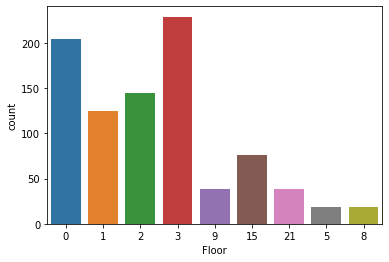

In [ ]:
sns.countplot(df.Floor);

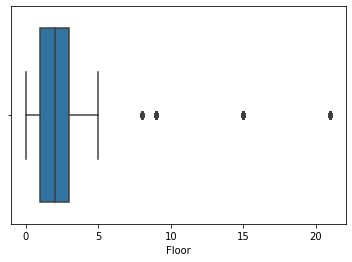

In [ ]:
sns.boxplot(df.Floor);

In [ ]:
for i in range(len(df)):
    value = re.split(r"[-;,.\s]\s*",df.Price.iloc[i])[1:3]
    df.Price.iloc[i] = int(value[0]) * 1000

In [ ]:
df.Price

0       8000
1      17000
2      10000
3       7000
4      13000
       ...  
994     8000
995     7000
996    22000
997     6000
998     8000
Name: Price, Length: 923, dtype: object

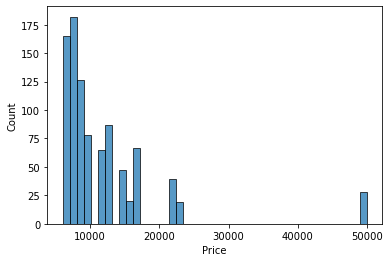

In [ ]:
sns.histplot(df.Price);

In [ ]:
df.head()

,Description,Weekend,Area,Age,Floor,Price
0,bir emlak'tan lizbon...,21,110,24,1,8000
1,çankaya sinpaş güney...,41,250,6,21,17000
2,anıttepe gençlik cad...,11,60,6,0,10000
3,kiralık 3+1 etlik ba...,31,140,20,0,7000
4,yalnızgül'den 3+1 1....,31,125,35,1,13000


In [ ]:
columns = ['Weekend','Area','Age','Price']
for col in columns:
    df[col] = df[col].astype("float")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 923 entries, 0 to 998
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Description  923 non-null    object 
 1   Weekend      923 non-null    float64
 2   Area         923 non-null    float64
 3   Age          923 non-null    float64
 4   Floor        895 non-null    object 
 5   Price        923 non-null    float64
dtypes: float64(4), object(2)
memory usage: 50.5+ KB


In [ ]:
df.Description.head(15)

0                               bir emlak'tan lizbon...
1                               çankaya sinpaş güney...
2                               anıttepe gençlik cad...
3                               kiralık 3+1 etlik ba...
4                               yalnızgül'den 3+1 1....
5                               hakim evi karşısında...
6                               2+1 eşyalı abonelikl...
7                               ada emlak güvencesiy...
8                               bulvar loft’da bahçe...
9                               doğa'dan a.eğlence g...
10                              aşık veysel mahalles...
11                              akarsu'dan sitede ka...
12                              zirwe'den ankara man...
13                              etimesgut alsancak b...
14                              emlak dünyasından ok...
Name: Description, dtype: object

## Data Cleaning

In [ ]:
df['Description']=df['Description'].str.lower()
df['Description']=df['Description'].str.replace("[^\w\s]","")
df['Description']=df['Description'].str.replace("\d+","")
df['Description']=df['Description'].str.replace("\n"," ").replace("\r","")
df['Description']=df['Description'].str.replace("   ", "")

In [ ]:
df.Description

0        bir emlaktan lizbon caddesi  yakını  kiralık...
1        çankaya sinpaş güneypark de  havuz manzaralı...
2        anıttepe gençlik caddesinde yeni bina  full ...
3        kiralık  etlik bağcı caddesi yakını full yap...
4        yalnızgüldenkat ön cephe kombili milli kütüp...
                             ...                        
994      uzunyıl şirintepe mah  sıfır bina ön cephe c...
995                cebecide tanyeli sokak  kiralık daire
996      turyaptan beker plazada kotopaklı ankastreli...
997                       mamak yeni bayındırda kiralık 
998      elissa gayrimenkulden  geniş teraslı kiralık...
Name: Description, Length: 923, dtype: object

In [ ]:
df.isna().sum()

Description     0
Weekend         0
Area            0
Age             0
Floor          28
Price           0
dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isna().sum()

Description    0
Weekend        0
Area           0
Age            0
Floor          0
Price          0
dtype: int64

In [ ]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

In [ ]:
def wc(data,bgcolor):
    plt.figure(figsize=(10,10))
    mask=np.array(Image.open("20581.png"))
    wc=WordCloud(background_color=bgcolor,stopwords=STOPWORDS,mask=mask)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis("off")

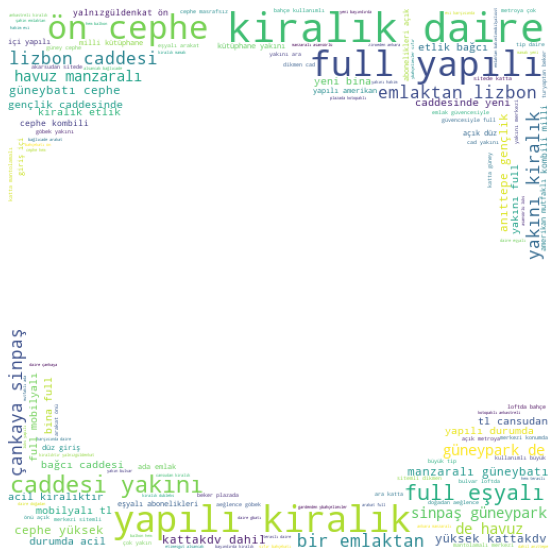

In [ ]:
wc(df["Description"],'white')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 895 entries, 0 to 998
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Description  895 non-null    object 
 1   Weekend      895 non-null    float64
 2   Area         895 non-null    float64
 3   Age          895 non-null    float64
 4   Floor        895 non-null    object 
 5   Price        895 non-null    float64
dtypes: float64(4), object(2)
memory usage: 48.9+ KB


In [ ]:
df.Floor = df.Floor.astype(float)

## Regression

In [ ]:
x=df.drop(["Description","Price"],axis=1)
y=df.Price

In [ ]:
def regression(x,y):
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Ridge,Lasso
    from sklearn.linear_model import ElasticNet
    from sklearn.tree import ExtraTreeRegressor
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.neighbors import KNeighborsRegressor

    from sklearn.model_selection import train_test_split

    from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error


    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

    L=LinearRegression()
    R=Ridge()
    Lass=Lasso()
    E=ElasticNet()
    ExTree=ExtraTreeRegressor()
    GBR=GradientBoostingRegressor()
    KN=KNeighborsRegressor()

    algos=[L,R,Lass,E,ExTree,GBR,KN]
    algo_names=['LinearRegression','Ridge','Lasso','ElasticNet','ExtraTreeRegressor','GradientBoostingRegressor','KNeighborsRegressor']
    r_squared=[]
    rmse=[]
    mae=[]

    result=pd.DataFrame(columns=['R_Squared','RMSE','MAE'],index=algo_names)

    for item in algos:
        item.fit(x_train,y_train)
        item.predict(x_test)
        r_squared.append(r2_score(y_test,item.predict(x_test)))
        rmse.append((mean_squared_error(y_test,item.predict(x_test)))**.5)
        mae.append(mean_absolute_error(y_test,item.predict(x_test)))

    result.R_Squared=r_squared
    result.RMSE=rmse
    result.MAE=mae

    return result.sort_values('R_Squared',ascending=False)

In [ ]:
regression(x,y)

,R_Squared,RMSE,MAE
ExtraTreeRegressor,0.997317,220.664010,40.825097
KNeighborsRegressor,0.997229,224.230528,16.759777
GradientBoostingRegressor,0.989764,430.979865,214.182561
ElasticNet,0.376260,3364.211168,2447.100835
Lasso,0.373061,3372.827900,2443.960875
Ridge,0.373039,3372.885711,2443.962393
LinearRegression,0.373030,3372.911270,2443.953325


## Deep Learning

In [ ]:
x = scaler.fit_transform(x)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.30, random_state=42)

In [ ]:
model=Sequential()

model.add(Dense(8192, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='Adam', loss='mse')

In [ ]:
model.fit(x=x_train,y=y_train,validation_data=(x_test,y_test),verbose=1,epochs=30)

Epoch 1/30
20/20 [==============================] - 15s 663ms/step - loss: 91257560.0000 - val_loss: 55103548.0000
Epoch 2/30
20/20 [==============================] - 12s 601ms/step - loss: 29501656.0000 - val_loss: 20950520.0000
Epoch 3/30
20/20 [==============================] - 13s 671ms/step - loss: 17968994.0000 - val_loss: 13448674.0000
Epoch 4/30
20/20 [==============================] - 15s 729ms/step - loss: 13005841.0000 - val_loss: 12126292.0000
Epoch 5/30
20/20 [==============================] - 13s 632ms/step - loss: 11168725.0000 - val_loss: 10961263.0000
Epoch 6/30
20/20 [==============================] - 13s 671ms/step - loss: 10552522.0000 - val_loss: 9971804.0000
Epoch 7/30
20/20 [==============================] - 13s 674ms/step - loss: 9299052.0000 - val_loss: 9758999.0000
Epoch 8/30
20/20 [==============================] - 13s 650ms/step - loss: 8502225.0000 - val_loss: 8056598.0000
Epoch 9/30
20/20 [==============================] - 13s 631ms/step - loss: 7955906.00

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              40960     
                                                                 
 dense_1 (Dense)             (None, 4096)              33558528  
                                                                 
 dense_2 (Dense)             (None, 2048)              8390656   
                                                                 
 dense_3 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 128)               3

In [ ]:
pred = model.predict(x_test)

9/9 [==============================] - 1s 60ms/step


In [ ]:
pred

array([[10516.701 ],
       [13068.926 ],
       [ 7411.3115],
       [ 9100.782 ],
       [24358.072 ],
       [10516.701 ],
       [10647.479 ],
       [19187.348 ],
       [13927.636 ],
       [10516.701 ],
       [ 7507.7593],
       [11404.378 ],
       [10330.373 ],
       [10330.373 ],
       [10647.479 ],
       [ 7950.1655],
       [19174.928 ],
       [15404.146 ],
       [ 9785.363 ],
       [17714.832 ],
       [ 7950.1655],
       [ 9523.461 ],
       [ 9100.782 ],
       [10516.701 ],
       [10260.471 ],
       [ 7507.7593],
       [ 9523.461 ],
       [ 9523.461 ],
       [13416.966 ],
       [13068.926 ],
       [10260.471 ],
       [ 9523.461 ],
       [ 9785.363 ],
       [10647.479 ],
       [11590.041 ],
       [10516.701 ],
       [10330.373 ],
       [17714.832 ],
       [ 7353.8945],
       [ 9436.531 ],
       [13927.636 ],
       [24358.072 ],
       [13927.636 ],
       [ 9068.955 ],
       [ 9436.531 ],
       [13416.966 ],
       [ 7883.0356],
       [13416

In [ ]:
(mean_squared_error(y_test, pred))**.5

1564.1192982717278

In [ ]:
r2_score(y_test, pred)

0.8801858803016009